# Extract Excerpt From Abstract Using LDA and Fine-Tuned ALBERT

In the following sections, we explain how we have developed a framework for finding answers for the next question: What do we know about the virus, the human immune response, and predictive models?

## Goal & Approach

Since the beginning of 2020, many articles addressing COVID-19 have been rapidly published. Due to the overflow of information, people in medical communities face difficulties getting helpful information that can answer their questions. This notebook provides an overview of information extraction to fight against the information overflow.

Our framework utilizes topic modeling to extract the relevant articles to COVID-19. Then, we use a pre-trained ALBERT model to get an excerpt from each article obtained from the previous methods that get answer questions related to COVID-19. The ALBERT model is pre-trained with two different datasets, SQuAD v1.1 and BioASQ 6b factoid QA pairs. SQuAD is a reading comprehension dataset with over 100k QA pairs. Since there is no publicly available ALBERT model pre-trained on the general QA task, we first utilize the SQuAD dataset so that our model targets explicitly the QA task. After pretraining on SQuAD v1.1, we fine-tune our model to the medical domain using BioASQ factoid QA pairs. 

The main advantage of our framework is that it can be applied to any queries related to COVID-19, as there is no additional tuning required. 
The diagram below shows the overall workflow of our approach to tackling the COVID19 task.

LDA+ALBERT.png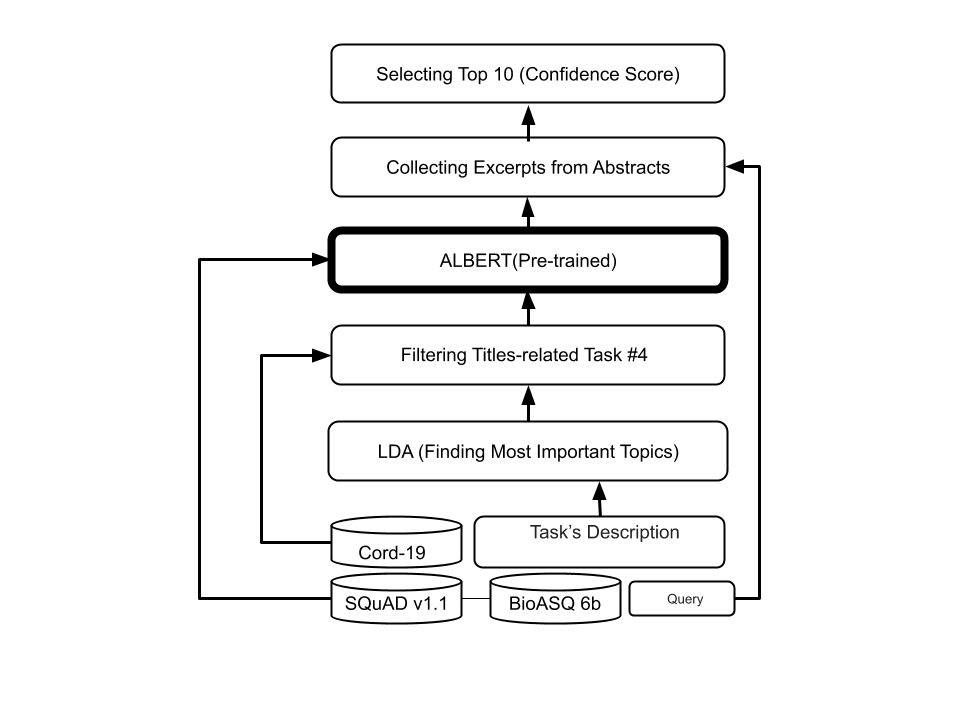

## Steps

0. [Install All Required Libraries](#step0)
1. [Filter for Only Question-Related Articles Using LDA](#step1)
2. [Load pretrained ALBERT model](#step2)
3. [Extract Excerpt From Abstract Using Fine-Tuned ALBERT](#step3)
4. [Get Top 10 relevant articles](#step4)
5. [Run over all 10 COVID-19 questions](#step5)
6. [Plot Confidence Score for Top 10 relevant articles](#step6)


<div id="step0"></div>

## Step 0. Install All Required Libraries

In [ ]:
# turn the internet on for this to install properly
!pip install transformers
!pip install colorama

In [ ]:
import numpy as np
import torch
import pandas as pd
import transformers
from tqdm import tnrange
from transformers import AlbertTokenizer, AlbertForQuestionAnswering
import colorama
import os
import re
import matplotlib.pyplot as plt

<div id="step1"></div>

## Step 1. Filter for Only Question-Related Articles Using LDA

We use the filtered articles extracted by **Latent Dirichlet Allocation** (LDA), a well-know topic modeling algorithm. Receiving words as an input vector LDA performs a generative process to provide topics that are probability distribution over words. The aim is to employ LDA to find the most important topics (a bunch of keywords) that are relevant to the description of task-4 (which is related to the question) and use them to find articles from the Cord-19 dataset (a dataset with 40K pieces) that have one of those topics in their titles. 
Since the output of topic modeling only contains the articles that have been proposed for the first round of submission, we have not included the articles added to the second round of introduction. 
The filtered articles are joined with "metadata.csv" to get detailed information on each article. 
After joining two data frames, the number of articles has been reduced to 15170 from 138794. 
Note: Due to the lack of suitable computational power, we used the Cord-19 dataset with 40K articles. 

In [ ]:
import pandas as pd
from tqdm import tnrange

def get_filtered_articles(path_to_filtered_articles, path_to_metadata):

  # Get filtered articles 
  data_filtered_titles = pd.read_csv(path_to_filtered_articles, usecols=['title'], keep_default_na = False) # length: 15291
  metadata = pd.read_csv(path_to_metadata, keep_default_na=False) # length: 138794

  # Get detailed information of the filtered articles from metadata
  df = pd.merge(data_filtered_titles, metadata) # length: 13667

  return df



In [ ]:
import pandas as pd
from tqdm import tnrange


# the file path containing titles of the filtered articles extracted by topic modeling
path_to_filtered_articles = '../input/covid19-related-articles/Ten_Tasks.csv'
path_to_metadata = '../input/CORD-19-research-challenge/metadata.csv'

data = get_filtered_articles(path_to_filtered_articles, path_to_metadata)
print(data.head())

<div id="step2"></div>

## Step 2. Load Pretrained ALBERT Model

[ALBERT](https://arxiv.org/abs/1909.11942) has similar architecture as other BERT models, but it is on the basis of a transformer encoder with Gaussian Error Linear Units (GELU) nonlinearities. ALBERT uses a different embedding method than BERT. In more detail, ALBERT uses two-step word embedding that first projects a word into a lower-dimensional embedding space and then extends it to the hidden space. Furthermore, ALBERT uses a cross-layer parameter sharing to improve parameter efficiency; it only uses feed-forward network (FFN) parameters across layers to share attention parameters. Another difference between ALBER and BERT is that ALBERT uses a sentence-order prediction (SOP) loss to avoid topic prediction and focus on modeling inter-sentence coherence.

We have pre-trained the ALBERT model with **[SQuAD v1.1](https://rajpurkar.github.io/SQuAD-explorer/)** followed by **BioASQ 6b** factoid datasets. The **SQuAD** dataset is a reading comprehension QA dataset posed by crowdworkers on Wikipedia articles, and the answer to each question is a span of text from the corresponding article. The BioASQ 6b dataset is biomedical semantic QA pairs, in which we assume that the contents are closely related to COVID-19. The limitation of pretraining with only **BioASQ** dataset is the lack of data. The primary reason for pretraining our ALBERT model with SQuAD v1.1 is to overcome the data shortage of using only **[BiOASQ](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0564-6)** dataset. 

We have pre-trained ALBERT base model with 3 different approaches (1) **SQuAD v1.1** only (2) **BioASQ 6b** factoid only (3) **SQuAD v1.1** followed by **BioASQ 6b** factoid. Each model is evaluated using **BioASQ** test dataset, and we have confirmed that the model pre-trained on both dataset have achieved the highest performance. Therefore, we will use the model with the most top performance for the COVID-19 task. 

The models are pre-trained using GPU available in google colab. The pretraining process using both **SQuAD v1.1** and **BioASQ 6b** factoid dataset took approximately two hours. 
The pre-rained model is uploaded in the input directory. 

In [ ]:
# Import fine-tuned ALBERT model. 

from transformers import AlbertTokenizer, AlbertForQuestionAnswering

def get_model(path_to_model):

  if torch.cuda.is_available():  
    print("GPU available")
    dev = "cuda:0" 
  else:  
    dev = "cpu"  

  print("Import pre-trained ALBERT model...")
  tokenizer = AlbertTokenizer.from_pretrained(path_to_model)
  model = AlbertForQuestionAnswering.from_pretrained(
      path_to_model).to(dev)
    
  print("Import Complete!")
  return tokenizer, model, dev

In [ ]:
path_to_model = '../input/albert-trained-on-squad-and-bioasq'

tokenizer, model, device = get_model(path_to_model)

<div id="step3"></div>

## Step 3. Extract Excerpt from Abstract Using Fine-Tuned ALBERT
We utilize the fine-tuned ALBERT model to get answers relevant to each COVID-19 questions. The abstract of each article is the context we use for extracting relevant answers to questions. The answer is a span of text from the abstract. The workflow can be broken down into the following steps. 

1. Tokenizing the question and the abstract of each article  
2. Feeding the fine-tuned model with the tokenized text
3. Calculating the confidence score of the start and end index for each token. 
4. Getting tokens with the maximum confidence score for start and end index in the abstract. 
5. Detokenizing and getting an answer (i.e. a span of text from the abstract).

After calculating the maximum start and end confidence score of each article, we average the two confidence scores. The average of the beginning and end index of the abstract is the corresponding article's confidence score. 

In [ ]:
import torch
from tqdm import tnrange

def extract_relevant_answer(model, tokenizer, data, question, device):
  confidence = []
  predictions = []
  start_end_idx = []
    
  for i in tnrange(len(data)):
    abstract = data.iloc[i]['abstract']
    input_ids = tokenizer.encode(question, abstract)
    input_ids = input_ids[0:512]
    
    sep_idx = input_ids.index(tokenizer.sep_token_id)
    token_type_ids = [0 if i <= sep_idx else 1 for i in range(len(input_ids))]

    input_ids_tensor = torch.tensor([input_ids]).to(device)
    token_type_ids_tensor = torch.tensor([token_type_ids]).to(device)
    
    start_scores, end_scores = model(input_ids_tensor, token_type_ids=token_type_ids_tensor)

    start_idx = start_scores.argmax()
    end_idx = end_scores.argmax()+1
    score = (start_scores.max() + end_scores.max()) / 2
    score = score.item()

    if start_idx <= 0 or end_idx <= 0 or end_idx<=start_idx:
      predictions.append("Not Relevant")
      score = float('-inf')
    else:
      tokens = tokenizer.convert_ids_to_tokens(input_ids[start_idx:end_idx])
      prediction = tokenizer.convert_tokens_to_string(tokens)
      predictions.append(prediction)
    
    confidence.append(score)
    start_end_idx.append([start_idx, end_idx])
    
  return predictions, confidence, start_end_idx

## Step 4. Get Top 10 relevant articles
We have sorted the articles in descending order based on the confidence score calculated from the above steps. After sorting the articles, we extract the top 10 articles.

Due to the time constraint, we have run the code using GPU in Google Colab and uploaded the output in "../input/covid19-top-articles". Remove the output files from the directory if you prefer running on your local machine.

<div id="step4"></div>

In [ ]:
import pandas as pd
import numpy as np

def top_n_answers(question, predictions, confidence, start_end_idx, data, n):

  print("Get top " + str(n) + " relevant articles & answers")
  confidence = np.array(confidence)
  top_n_scores_idx = (-confidence).argsort()[:n]

  top_n_articles = pd.DataFrame()
  for idx in top_n_scores_idx:
    entry = data.iloc[idx]
    entry['confidence'] = confidence[idx]
    entry['prediction'] = predictions[idx]
    top_n_articles = top_n_articles.append(entry)
    
  top_n_articles.to_csv(question + ".csv")

  return top_n_articles

### Step 4.1. Print the Top Relevant Articles with an Highlighted Excerpt

In [ ]:
import colorama

def print_top_n_articles(question, top_n_articles):

  print("Prediction highlighted in red....")
  print("========  " + question + "  ======== ")
    
  for i in range(len(top_n_articles)):
    entry = top_n_articles.iloc[i]

    abstract = entry['abstract']
    prediction = entry['prediction']

    prediction_start_idx = abstract.find(prediction)
    prediction_end_idx = prediction_start_idx + len(prediction)
    
    
    print( "(" + str(i) + ")")
    print("Title : " + entry['title'] + "\n")
    print("Confidence: " + str(entry['confidence']))
    print("Abstract : " + abstract[:prediction_start_idx])
    print (colorama.Fore.RED, abstract[prediction_start_idx: prediction_end_idx].rstrip())
    print(colorama.Style.RESET_ALL, abstract[prediction_end_idx:] + "\n")




In [ ]:
question = 'What do we know about vaccines and therapeutics?'

file_path = os.path.join('../input/covid19-top-articles', question.replace('?','').replace(',','') + '_.csv')

if os.path.exists(file_path):
    top_n_articles = pd.read_csv(file_path)
else:
    # Extract relevant span of text
    predictions, confidence, start_end_idx = extract_relevant_answer(model, tokenizer, data, question, device)

    # Get the top n articles sorted by confidence scores
    n = 10
    top_n_articles = top_n_answers(question, predictions, confidence, start_end_idx, data, n)

# Print top n relevant articles
print_top_n_articles(question, top_n_articles)

<div id="step5"></div>

## Step 5. Run over All 10 COVID-19 Questions

We have run the same approach for all the questions currently posted on Kaggle. Again, we have run the code with GPU in Google Colab due to the time constraint. Remove the files from "../input/covid19-top-articles" if you prefer to run on your local machine. 

In [ ]:
# STEP 1: 
# the file path containing titles of the filtered articles extracted by topic modeling
path_to_filtered_articles = '../input/covid19-related-articles/Ten_Tasks.csv'
path_to_metadata = '../input/CORD-19-research-challenge/metadata.csv'
# Get filtered articles
data = get_filtered_articles(path_to_filtered_articles, path_to_metadata)

# STEP 2: Load the pretrained model
path_to_model = '../input/albert-trained-on-squad-and-bioasq'
tokenizer, model, device = get_model(path_to_model)

# STEP 3: Extract Excerpt From Abstract Using Fine-Tuned ALBERT
questions = ['What is known about transmission, incubation, and environmental stability?',
             'What do we know about COVID-19 risk factors?',
             'What do we know about vaccines and therapeutics?',
             'What do we know about virus genetics, origin, and evolution?',
             'What has been published about medical care?',
             'What do we know about non-pharmaceutical interventions?',
             'What has been published about ethical and social science considerations?',
             'What do we know about diagnostics and surveillance?',
             'What has been published about information sharing and inter-sectoral collaboration?',
             'What do we know about the virus, the human immune response and predictive models?']

confidence_matrix = np.zeros(shape=(10,10))
for i in range(len(questions)):
    question = questions[i]
    file_path = os.path.join('../input/covid19-top-articles', question.replace('?','').replace(',','') + '_.csv')
    print(file_path)
    if os.path.exists(file_path):
        top_n_articles = pd.read_csv(file_path)
    else:
        print("File doesn't exist!")
        predictions, confidence, start_end_idx = extract_relevant_answer(model, tokenizer, data, question, device)
        
        # STEP 4: Get the top n articles sorted by confidence scores
        n = 10
        top_n_articles = top_n_answers(question, predictions, confidence, start_end_idx, data, n)
        
    # Get confidence score and store in numpy array
    confidence_matrix[i] = top_n_articles['confidence']
    # Print top n relevant articles
    print_top_n_articles(question, top_n_articles)

<div id="step6"></div>


## Step 6. Plot Confidence Score for Top 10 Relevant Articles

This section visualizes the confidence score of each question, mean confidence scores of the top 10 articles, and comparison of the confidence score of the 1st relevant articles of each questions. 

In [ ]:
# Lables on x axis
x = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

# Plot a bar chart for each question.
fig, axs = plt.subplots(6,2,figsize=(15,15))

for i in range(len(confidence_matrix)):
    row = int(i / 2)
    col = int(i % 2)
    axs[row,col].bar(x, confidence_matrix[i])
    axs[row,col].set_title(questions[i])
    axs[row,col].set_ylim([4, 9])
    axs[row,col].set_xlabel('Rank')
    axs[row,col].set_ylabel('Confidence')
    
# Plot mean confidence score of each rank 
confidence_mean = np.mean(confidence_matrix, axis = 0) 
axs[5,0].bar(x, confidence_mean, color='orange')
axs[5,0].set_title("Average per rank") 
axs[5,0].set_ylim([4, 9])
axs[5,0].set_xlabel('Rank')
axs[5,0].set_ylabel('Confidence')

# Compare the confidence score of the 1st relevant article of each question
qs = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8","Q9", "Q10"]
axs[5,1].bar(qs, confidence_matrix[:,0], color='green')
axs[5,1].set_title("1st relevant articles with different questions") 
axs[5,1].set_ylim([4, 9])
axs[5,1].set_xlabel('Question #')
axs[5,1].set_ylabel('Confidence')

# Plot
fig.tight_layout(pad=2.0)

## Conclusion

We have tackled the COVID19 challenge competition by utilizing LDA for extracting the COVID19-related articles and applying a fined-tuned ALBERT model to extract answers from the top 10 articles with the highest confidence score. The visualization of our result above shows that each question gets satisfactory results with the corresponding reliable confidence score, mostly higher than 6. Since there is no additional tuning required for each question, our approach can be extended to answer other types of questions in the biomedical domain. 

Our work is a continuation of the work in https://www.kaggle.com/mahparsa/sbert-bert-for-cord-19-data 